In [1]:
import lecroy
#import rigol
import numpy as np
from matplotlib import pyplot as plt
from my_utils import *
from sigproc_kit import *
import time


from fst import *
from my_utils import *

import micos_eco
import phidrive

LECROY,WR620ZI,LCRY2805N57162,8.5.1


In [2]:
#%matplotlib notebook

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg')
#plt.rcParams["figure.figsize"] = (8,5)

clear_data_dir()

In [3]:
##################################################
##                init PASTTREC                 ##
##################################################

import pasttrec_ctrl as ptc

channel = 7
my_baseline = 6

#ptc.init_board("0001",1,15,4,127)
#ptc.init_board("0001",1,20,2,127) # alternative setting, pkt 20, gain 2, does the model still hold?
#ptc.init_board("0001",1,10,1,127) # alternative setting
#ptc.set_baseline("0001",1,channel,my_baseline) 
# zero V baseline for my channel relative to thr=0 - > scan said baseline at 5

x = 78.5
y = 71

phi = 0

thresh = 30

if True:
    micos_eco.move(x=x,y=y)
    if (phi != phidrive.get_angle() ): 
        phidrive.set_angle(phi)
    ptc.init_active_boards()
    ptc.set_threshold_for_board_by_name("0009",thresh)
    ptc.set_threshold_for_board_by_name("0014",thresh)



Welcome to JupyROOT 6.14/04
(78.5, 71.0, 0.0)
done
init board 0009
set baselines of the following channels
[16, 17, 18, 19, 20, 21, 22, 23, 24]
to the following values
[1.0, 5.0, -1.0, 7.0, 5.0, 4.0, 3.0, 7.0, 6.0]
set baselines of the following channels
[24, 25, 26, 27, 28, 29, 30, 31]
to the following values
[6.0, -0.0, 1.0, 0.0, -4.0, 3.0, 2.0, 4.0]
init board 0014
set baselines of the following channels
[0, 1, 2, 3, 4, 5, 6, 7, 8]
to the following values
[4.0, 4.0, 8.0, 0.0, 2.0, 4.0, -1.0, 5.0, 5.0]
set baselines of the following channels
[8, 9, 10, 11, 12, 13, 14, 15]
to the following values
[5.0, 5.0, 1.0, 5.0, -0.0, -0.0, 4.0, 1.0]


In [4]:
##################################################
##           configure LeCroy Scope             ##
##################################################

lecroy.clear_all()
lecroy.set_tdiv(100e-9)

# access scope sources by labels
s = {
    "PASTTREC_LVDS"    :"C1", # use LeCroy ZD1500 differential probe
    "PASTTREC_analog"  :"C2",  # set to 50R DC
    "UFSD"  :"C4"  # set to 50R DC
}

# set vertical amplifications and offsets
lecroy.set_vdiv(              s["PASTTREC_LVDS"],200e-3)
lecroy.set_voffset(           s["PASTTREC_LVDS"],0 ) 
lecroy.set_vdiv(              s["PASTTREC_analog"],100e-3)
lecroy.set_voffset(           s["PASTTREC_analog"],-800e-3 ) 

lecroy.set_vdiv(              s["UFSD"],50e-3)
lecroy.set_voffset(           s["UFSD"],0 ) 

#lecroy.set_vdiv(              s["PASTTREC_analog"],abs(test_amp *1e12)/2.*1.2 )
#lecroy.set_voffset(           s["PASTTREC_analog"],-1000e-3 )


# access scope measurements by labels
m = {
    "PASTTREC_t1"  : "p3",
    "PASTTREC_tot" : "p4"
}

# TDC measurements for differential probe at 100R terminated PASTTREC LVDS output
lecroy.setup_measurement(m["PASTTREC_t1"] ,s["PASTTREC_LVDS"],"delay")
lecroy.setup_measurement(m["PASTTREC_tot"],s["PASTTREC_LVDS"],"widthn")


# access scope trigger channels by labels

t = {
    "UFSD" : "C4",
}

lecroy.set_trig_source(t["UFSD"])
# trigger threshold = -35 mV -> set by hand

t1: 57.248ns, tot: 4.225ns
saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/000.svg
saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/000.pickle


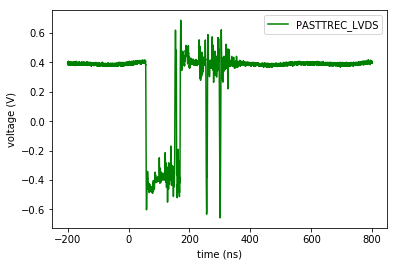

saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/001.svg
saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/001.pickle


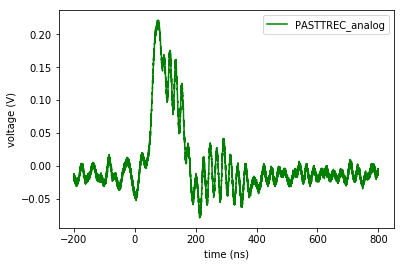

saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/002.svg
saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/002.pickle


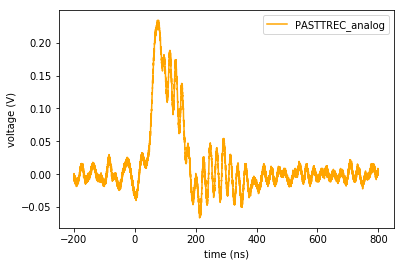

saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/003.svg
saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/003.pickle


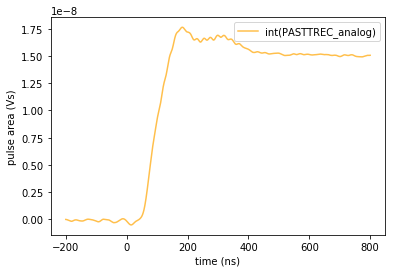

In [5]:
##################################################
##      capture ana waveform and LVDS out       ##
##################################################




time, wfm = lecroy.capture_waveforms([
    s["PASTTREC_LVDS"],
    s["PASTTREC_analog"],
    s["UFSD"]    
  ],
    average=1
)

t1 =  lecroy.read_measure(m["PASTTREC_t1"])
tot = lecroy.read_measure(m["PASTTREC_tot"])

print("t1: {:3.3f}ns, tot: {:3.3f}ns".format(t1*1e9,tot*1e9))

time_ns = time*1e9

# remove analog signal baseline, calculate bl from the first 10% of the sample
pt_ana = wfm[s["PASTTREC_analog"]]
pt_ana = remove_baseline(pt_ana,fraction=0.08)

plt.plot(time_ns,wfm[s["PASTTREC_LVDS"]] ,"g" ,label="PASTTREC_LVDS")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
show(plt)

plt.plot(time_ns,wfm[s["PASTTREC_analog"]] ,"g" ,label="PASTTREC_analog")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
show(plt)

plt.plot(time_ns,pt_ana,"orange",label="PASTTREC_analog")
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("voltage (V)")
show(plt)

##################################################
##                 Output integral              ##
##################################################

plt.plot(time_ns,     integrate_dt(time,     pt_ana) ,"orange",alpha=0.7 ,label="int(PASTTREC_analog)")


plt.legend()
plt.xlabel("time (ns)")
plt.ylabel("pulse area (Vs)")
#plt.xlim(0,400)
show(plt)

In [6]:
### measure a bunch of waveforms:

data_list = []

events = 1000

for i in range(0,events):
  time, wfm = lecroy.capture_waveforms([
    s["PASTTREC_LVDS"],
    s["PASTTREC_analog"],
    s["UFSD"]    
  ],
    average=1
  )

  t1 =  lecroy.read_measure(m["PASTTREC_t1"])
  tot = lecroy.read_measure(m["PASTTREC_tot"])

  data_list += [ 
    { 
      "t1" : t1,
      "tot" : tot,
      "time" : time,
      "LVDS" : wfm[s["PASTTREC_LVDS"]],
      "analog" : wfm[s["PASTTREC_analog"]],
      "UFSD" : wfm[s["UFSD"]],
    }
  ]
  print("{:d}  ".format(i),end="")

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  110  111  112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127  128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143  144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159  160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175  176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191  192  193  194  195  196  197  198  199  200  201  202  203  204  205  206  207  208  209  210  211  212  213  214  215  216  217  218  219  220  221  

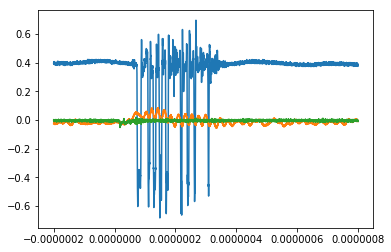

In [7]:
dataset = data_list[500]

plt.plot(dataset["time"],dataset["LVDS"])
plt.plot(dataset["time"],dataset["analog"])
plt.plot(dataset["time"],dataset["UFSD"])
plt.show()

In [8]:
pickle_this(data_list,"data_list")

saving to /workdir/jupyter/PASTTREC/cosy19_ana_data/data_list.pickle


In [10]:
archive(label="thr30_1000evt")

archived to ./archive/2019-11-10_11-18-22_cosy19_ana_thr30_1000evt


##################################################
##           PASTTREC threshold scan            ##
##################################################




lecroy.set_trig_source(t["RIGOL_AWG_SYNC1"])


thresholds = range(0,32,1)
baselines = range(-15,16,1)

n=10

meta_stats = {}


c = 0
for i in thresholds:
  ptc.set_threshold("0001",1,0,i) # tdc, conn, chip thresh
  meta_stats[i] = lecroy.measure_statistics(["P3","P4"],n)
  #time.sleep(0.1)
  c += 1


ptc.set_threshold("0001",1,0,0) # tdc, conn, chip thresh
for j in baselines:
  ptc.set_baseline("0001",1,channel,j) 
  meta_stats[my_baseline-j] = lecroy.measure_statistics(["P3","P4"],n)
  #time.sleep(0.1)
  c += 1



c = 0
my_ysteps = list(meta_stats.keys())
my_ysteps.sort()

scat_y          = np.zeros(len(my_ysteps)*n)
scat_x_leading  = np.zeros(len(my_ysteps)*n)
scat_x_trailing = np.zeros(len(my_ysteps)*n)

for i in my_ysteps:
  for j in range(0,n):
    scat_y[c] = i
    xl = meta_stats[i]["P3"][j]
    xt = meta_stats[i]["P3"][j] + meta_stats[i]["P4"][j]
    scat_x_leading[c] = xl # median filtered
    scat_x_trailing[c] = xt # median filtered
    c+=1


scat_x_leading *= 1e9
scat_x_trailing *= 1e9

scat_y *= 0.001895


plt.plot(time_ns,pt_ana,"orange",label="PASTTREC_analog")
plt.plot(time_ns,np.zeros(len(time_ns)),"red",label="baseline")
plt.scatter(scat_x_leading,scat_y  ,label="lvds leading edges", c="g",alpha=0.4)
plt.scatter(scat_x_trailing,scat_y ,label="lvds trailing egdes",c="r",alpha=0.4)
#plt.plot(scx,ana_wav,label="analog waveform")
plt.xlabel("time (ns)")
plt.ylabel("analog voltage (V), thresh DAC: 2mV/LSB")
plt.legend()
show(plt)






ana_offset_ns=9
ana_offset_mV=4.2

plt.plot(time_ns+ana_offset_ns,1e3*pt_ana,"orange",label="PASTTREC_analog",alpha=0.4)
plt.plot(time_ns+ana_offset_ns,1e3*(pt_ana+ana_offset_mV*1e-3),"blue",label="PASTTREC_analog + 4.2 mV hysteresis",alpha=0.4)
plt.plot(time_ns+ana_offset_ns,1e3*(pt_ana-ana_offset_mV*1e-3),"violet",label="PASTTREC_analog - 4.2 mV hysteresis",alpha=0.4)
plt.plot(time_ns,np.zeros(len(time_ns)),"red",label="baseline")
plt.scatter(scat_x_leading,0.96*1e3*scat_y  ,label="lvds leading edges", c="g",alpha=0.2)
plt.scatter(scat_x_trailing,0.96e3*scat_y ,label="lvds trailing egdes",c="r",alpha=0.2)
plt.xlabel("time (ns)")
plt.ylabel("analog voltage (mV), thresh DAC: 2mV/LSB")
plt.legend()
plt.xlim(90,250)
plt.ylim(-20,70)
show(plt)